# Experiment 04

The first trial of BERT transformer. 

Tutorial link https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import multiprocessing as mp

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS_PALETTE = ['green', 'red']

sns.set_palette(sns.color_palette(COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device(
    'cuda:0' if torch.cuda.is_available() else 'cpu'
)

## Load data

In [2]:
# Load jigsaw and ctec datasets 
jigsaw_df = pd.read_csv('train_preproc_shrk.csv')
ctec_df = pd.read_csv('ctec_training_data_preproc.csv')

# target >= 0.5 --> toxic --> label = 1
# target < 0.5 --> non-toxic --> label = 0
jigsaw_df.loc[jigsaw_df['target'] >= 0.5, 'label'] = 1
jigsaw_df.loc[jigsaw_df['target'] < 0.5, 'label'] = 0

# Split by label 
jigsaw_neg = jigsaw_df[jigsaw_df['label'] == 0]
jigsaw_pos = jigsaw_df[jigsaw_df['label'] == 1]
ctec_neg = ctec_df[ctec_df['label'] == 0]
ctec_pos = ctec_df[ctec_df['label'] == 1]

# Show number of positive and negative examples in each dataset 
print(f'jigsaw # negative examples = {jigsaw_neg.shape[0]}')
print(f'jigsaw # positive examples = {jigsaw_pos.shape[0]}')
print(f'ctec # negative examples = {ctec_neg.shape[0]}')
print(f'ctec # positive examples = {ctec_pos.shape[0]}')

# Create training set and test set based on the scheme described above

# Randomly sampling indices 
indpos = np.random.choice(range(ctec_pos.shape[0]), size = 10000, replace = False)
indneg = np.random.choice(range(ctec_neg.shape[0]), size = 500, replace = False)
notindpos = np.setdiff1d(range(ctec_pos.shape[0]), indpos)
notindneg = np.setdiff1d(range(ctec_neg.shape[0]), indneg)

# X_trainval in text format, and y_trainval
# All jigsaw examples plus sampled ctec examples
X_trainval_text = jigsaw_df['comment_text'].append(
    ctec_pos['comment_text'].iloc[indpos], 
    ignore_index = True
).append(
    ctec_neg['comment_text'].iloc[indneg], 
    ignore_index = True
)

y_trainval = jigsaw_df['label'].append(
    ctec_pos['label'].iloc[indpos], 
    ignore_index = True
).append(
    ctec_neg['label'].iloc[indneg], 
    ignore_index = True
)

# X_test in text format, and y_test 
X_test_text = ctec_neg['comment_text'].iloc[notindneg].append(
    ctec_pos['comment_text'].iloc[notindpos], 
    ignore_index = True
)

y_test = ctec_neg['label'].iloc[notindneg].append(
    ctec_pos['label'].iloc[notindpos], 
    ignore_index = True
)

jigsaw # negative examples = 18386
jigsaw # positive examples = 1614
ctec # negative examples = 1901
ctec # positive examples = 21600


Text(0.5, 1.0, 'Test set')

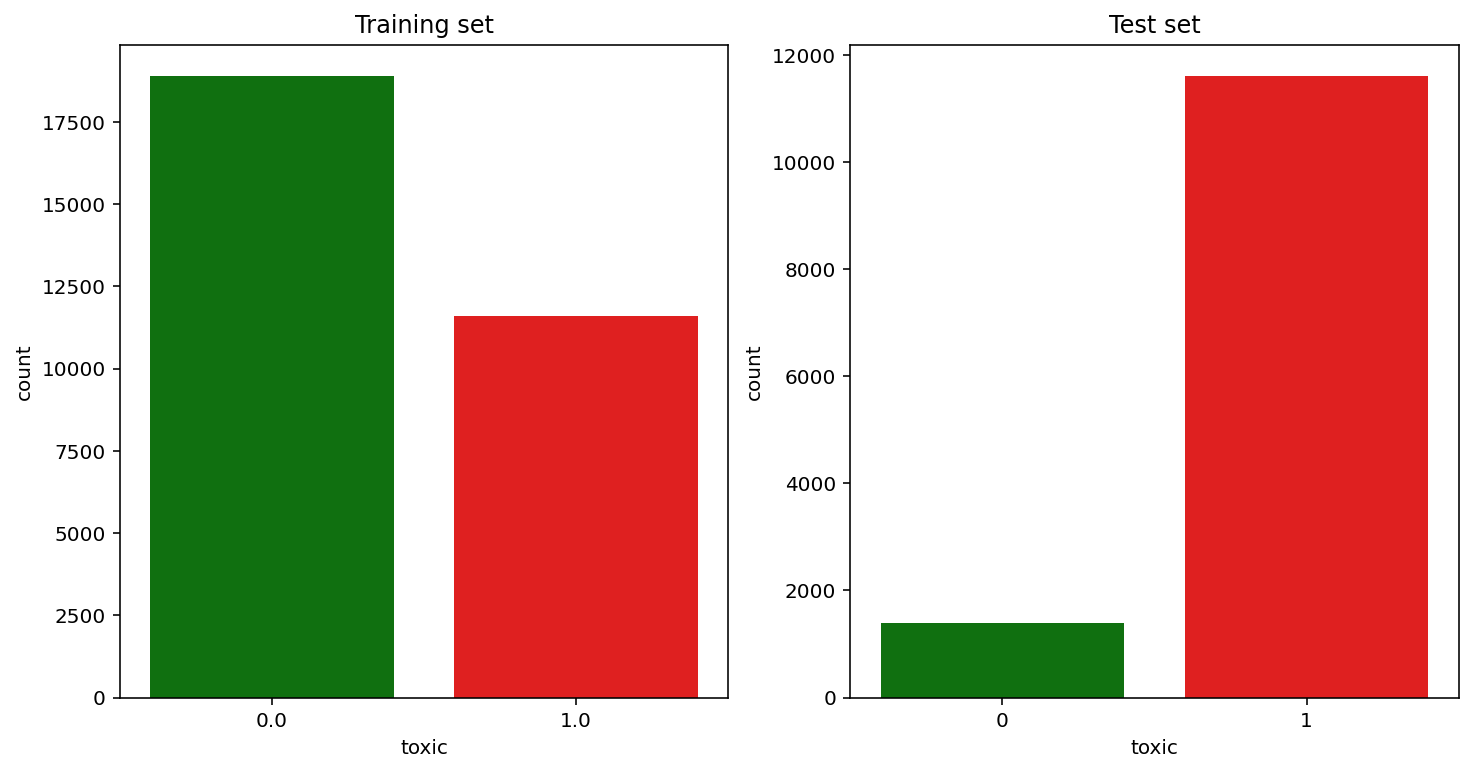

In [3]:
ax1 = plt.subplot(121)
sns.countplot(y_trainval)
plt.xlabel('toxic')
plt.title('Training set')

ax2 = plt.subplot(122)
sns.countplot(y_test)
plt.xlabel('toxic')
plt.title('Test set')

## BERT basics

If there is any unexpected error with ipywidget, run the following commands: 

```
$ conda install -c conda-forge ipywidgets
$ jupyter nbextension enable --py widgetsnbextension
```

### Tokens

In [4]:
# Case-insensitive version of BERT tokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Illustrate how tokenization works 
sample_txt = 'Yall gon make me lose my mind! wtf'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence = {sample_txt}')
print(f'Tokens = {tokens}')
print(f'Token IDs = {token_ids}')

Sentence = Yall gon make me lose my mind! wtf
Tokens = ['ya', '##ll', 'go', '##n', 'make', 'me', 'lose', 'my', 'mind', '!', 'w', '##tf']
Token IDs = [8038, 3363, 2175, 2078, 2191, 2033, 4558, 2026, 2568, 999, 1059, 24475]


Here are some special tokens provided by `BertTokenizer`. 

In [5]:
# End of sentence
print(tokenizer.sep_token, tokenizer.sep_token_id)

# Must add this to the start of each sentence, so BERT knows we are doing classification
print(tokenizer.cls_token, tokenizer.cls_token_id)

# Padding
print(tokenizer.pad_token, tokenizer.pad_token_id)

# Unknown 
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


We use `encond_plus()` method to do all the necessary works. Running the following cell and we will see how `sample_txt` is encoded with special tokens and other info. 

In [6]:
encoding = tokenizer.encode_plus(
    sample_txt, 
    max_length = 32,  # Encoded as a 32-dim tensor
    add_special_tokens = True,  # Add [CLS] and [SEP]
    return_token_type_ids = False, 
    pad_to_max_length = True, 
    return_attention_mask = True, 
    return_tensors = 'pt'   # return PyTorch tensors 
)

encoding

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'input_ids': tensor([[  101,  8038,  3363,  2175,  2078,  2191,  2033,  4558,  2026,  2568,
           999,  1059, 24475,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

We can also perform the inverse operation of finding tokens given IDs. 

In [7]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'ya', '##ll', 'go', '##n', 'make', 'me', 'lose', 'my', 'mind', '!', 'w', '##tf', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


## Preprocessing

### Choosing sequence length

BERT only works with fixed-length sequences, therefore we need to choose a max length. 

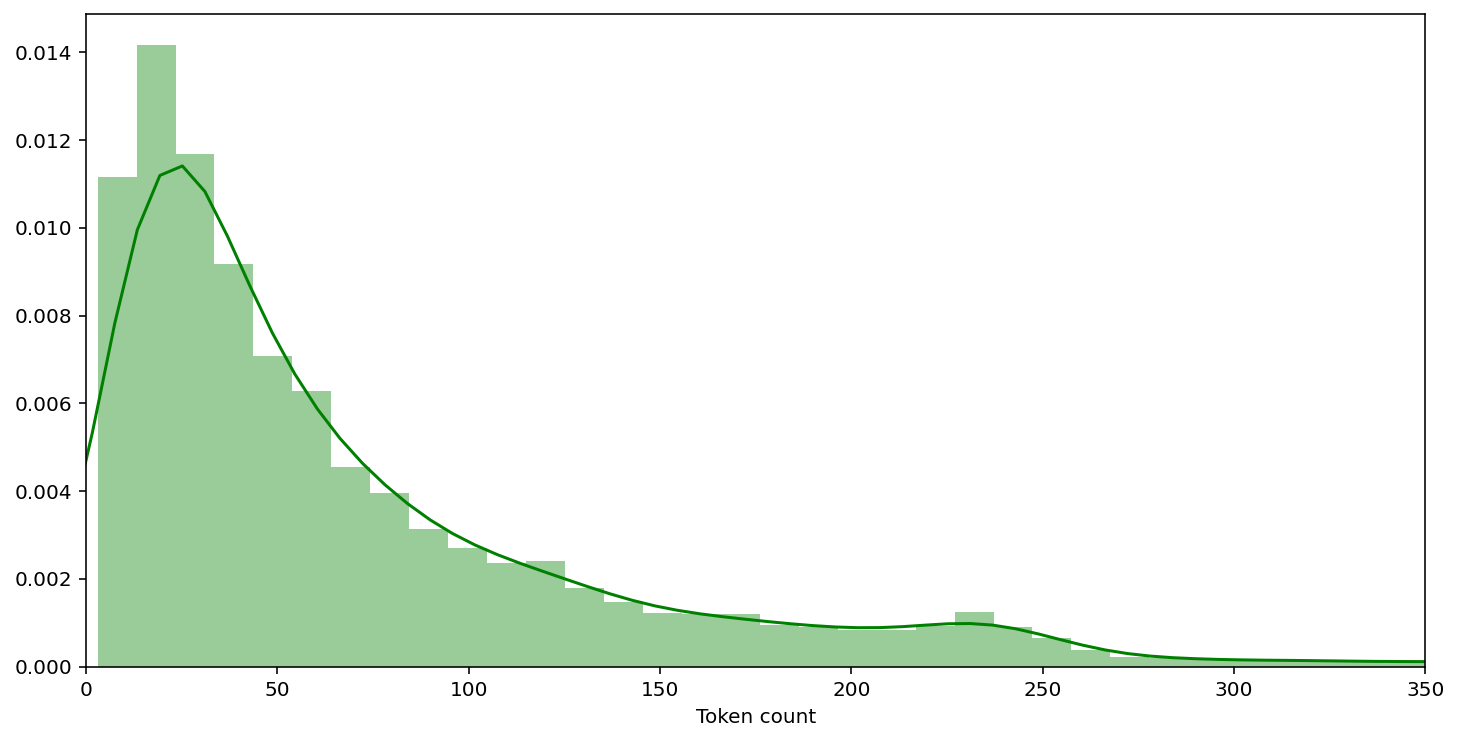

In [8]:
# We don't need to run this cell in the future 

token_lens = []

for text in X_trainval_text: 
    tokens = tokenizer.encode(text, truncation = True, max_length = 512)
    token_lens.append(len(tokens))
    
for text in X_test_text: 
    tokens = tokenizer.encode(text, truncation = True, max_length = 512)
    token_lens.append(len(tokens))
    
token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 350]);
plt.xlabel('Token count');


Most of the texts contain less than 250 tokens. To be on the safe side, we choose a maximum length of 300. 

In [9]:
MAX_LEN = 300

Now we have everything we need to create a PyTorch `Dataset` class. 

In [10]:
class ToxicDataset(Dataset): 
    def __init__(self, texts, labels, tokenizer, max_len):
        super().__init__()
        self.texts = texts 
        self.labels = labels
        self.tokenizer = tokenizer 
        self.max_len = max_len
        
    def __len__(self): 
        return len(self.texts)
    
    # This method must be overwritten in a PyTorch Dataset class 
    def __getitem__(self, idx): 
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text, 
            add_special_tokens = True, 
            truncation = True, 
            max_length = self.max_len, 
            return_token_type_ids = False, 
            pad_to_max_length = True, 
            return_attention_mask = True, 
            return_tensors = 'pt'
        )
        
        return {
            'text': text, 
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype = torch.long)
        }
        

In [11]:
df_trainval = pd.concat([X_trainval_text, y_trainval], axis = 1)
df_test = pd.concat([X_test_text, y_test], axis = 1)

# Split in to training set and validation set 
df_train, df_val = train_test_split(
    df_trainval, 
    test_size = 0.1, 
    random_state = RANDOM_SEED 
)

We also need to create `DataLoader`. Data loader combines dataset and a sampler, providing an iterable over the given dataset. 

In [12]:
def create_data_loader(df, tokenizer, max_len, batch_size): 
    ds = ToxicDataset(
        texts = df['comment_text'].to_numpy(), 
        labels = df['label'].to_numpy().astype(int), 
        tokenizer = tokenizer, 
        max_len = max_len
    )
    
    return DataLoader(
        ds, 
        batch_size = batch_size, 
        num_workers = 0 #mp.cpu_count() - 1
        # Multiprocessing is not working correctly on my machine
    )

BATCH_SIZE = 16

train_data_loader = create_data_loader(
    df_train, tokenizer, MAX_LEN, BATCH_SIZE
)

val_data_loader = create_data_loader(
    df_val, tokenizer, MAX_LEN, BATCH_SIZE
)

test_data_loader = create_data_loader(
    df_test, tokenizer, MAX_LEN, BATCH_SIZE
)

To see how `DataLoader` works, here is an example batch from our data loader. Observe that the size of fetched data from an iteratino matches `BATCH_SIZE`. 

In [13]:
# The iterator from DataLoader
iterator = iter(train_data_loader)

# Fetch `BATCH_SIZE` examples per iteration
data = next(iterator)

print(f'Keys of dictionary = {data.keys()}')
print(f'Batch size = {BATCH_SIZE}')
print('Shape of input_ids = {}'.format(data['input_ids'].shape))
print('Shape of attention_masks = {}'.format(data['attention_mask'].shape))
print('Shape of labels = {}'.format(data['label'].shape))

Keys of dictionary = dict_keys(['text', 'input_ids', 'attention_mask', 'label'])
Batch size = 16
Shape of input_ids = torch.Size([16, 300])
Shape of attention_masks = torch.Size([16, 300])
Shape of labels = torch.Size([16])


## Classification

### Illustration

There are a lot of helper classes and functions that make using BERT easier, such as `BertForSequenceClassifier`, `BertForQuestionAnswering`. For now we will instead build everything from scratch. 

In [14]:
# Load the model 
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

For illustration purpose, we apply `bert_model` on our sample text. 

`last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying `BertPooler` on `last_hidden_state`. 

In [15]:
# BERT model takes input_id and attention_mask as parameters 
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'], 
    attention_mask = encoding['attention_mask']
)

print(last_hidden_state.shape)
print(bert_model.config.hidden_size)
print(pooled_output.shape)

torch.Size([1, 32, 768])
768
torch.Size([1, 768])


For each of our 32 tokens, we have a 768-dim hidden state. 

Now we create a classifier. 

In [16]:
class ToxicClassifier(nn.Module): 
    def __init__(self, n_classes): 
        super(ToxicClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        # Dropout rate
        self.drop = nn.Dropout(p = 0.3)
        # From the last hidden layer to the last layer 
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask): 
        # BERT model returns the last hidden layer
        _, pooled_output = self.bert(
            input_ids = input_ids, 
            attention_mask = attention_mask
        )
        # Drop out according to dropout rate
        output = self.drop(pooled_output)
        # Return the last layer 
        return self.out(output)

In [17]:
# Binary classification 
n_classes = 2

# Instantiate the model and move it to GPU if possible 
model = ToxicClassifier(n_classes)   # 
model = model.to(device)

(For illustration purpose) We will move the example batch of our training data to GPU. 

In [18]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 300])
torch.Size([16, 300])


(For illustration purpose) run our model on our example batch. 

In [19]:
%time F.softmax(model(input_ids, attention_mask), dim = 1)

CPU times: user 1min 1s, sys: 18.3 s, total: 1min 20s
Wall time: 37 s


tensor([[0.5473, 0.4527],
        [0.5347, 0.4653],
        [0.3281, 0.6719],
        [0.4968, 0.5032],
        [0.5944, 0.4056],
        [0.4113, 0.5887],
        [0.5502, 0.4498],
        [0.5478, 0.4522],
        [0.5375, 0.4625],
        [0.5301, 0.4699],
        [0.6259, 0.3741],
        [0.5608, 0.4392],
        [0.4844, 0.5156],
        [0.6287, 0.3713],
        [0.4604, 0.5396],
        [0.7107, 0.2893]], grad_fn=<SoftmaxBackward>)

### Training

Here are the recommendation for fine tuning given by the BERT authors. 

    Batch size: 16, 32
    Learning rate (Adam): 5e-5, 3e-5, 2e-5
    Number of epochs: 2, 3, 4

In [20]:
EPOCHS = 10 

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# len(train_data_loader) = number of iterations to finish an epoch
# = number of batches in an epoch 
total_steps = len(train_data_loader)

# Linear scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, 
    num_training_steps = total_steps
)

# Loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

We define 2 helper functions, `train_epoch` and `eval_model`, that are needed for training. 

In [21]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
): 
    # Set the model in training mode 
    model = model.train()
    
    losses = []    # For plotting learning curve 
    # label, pred_class
    # 00 --> true negative 
    # 01 --> false positive 
    # 10 --> false negative 
    # 11 --> true positive 
    cat_counts = [0, 0, 0, 0]
    
    for batch in data_loader: 
        # Load data from current batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Feed forward on current batch
        outputs = model(
            input_ids = input_ids, 
            attention_mask = attention_mask
        )
        
        # torch.max with dim=1 returns (maxvals, indices)
        # indices are the labels we want to predict 
        preds_prob, preds_class = torch.max(outputs, dim = 1)
        
        # Compute which category each examples falls in
        # 00 --> true negative 
        # 01 --> false positive 
        # 10 --> false negative 
        # 11 --> true positive 
        cats = 2 * labels  + preds_class
        # Count each category 
        for i in range(4): 
            cat_counts[i] += (cats == i).sum().item()
        
        # Calculate loss
        loss = loss_fn(outputs, targets)
        
        # For analysis purpose 
        losses.append(loss.item())
        
        # Backprop
        loss.backward()
        # clipgrad_norm is for avoiding gradient explosion
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        # Scheduler is called everytime a batch is fed to the model
        scheduler.step()
        # Clear the gradients of optimizer 
        optimizer.zero_grad()
    
    # Train accuracy of epoch
    acc = (cat_counts[0] + cat_counts[3]) / cat_counts
    # F1 score assuming positive example is scarce
    f1_pos = cat_counts[3] / (cat_counts[3] + .5 * cat_counts[1] + .5 * cat_counts[2])
    # F1 score assuming negative example is scarce 
    f1_neg = cat_counts[0] / (cat_counts[0] + .5 * cat_counts[1] + .5 * cat_counts[2])
    
    return np.mean(losses), acc, f1_pos, f1_neg

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    # Set the model in evaluation mode 
    model = model.eval()
    
    losses = []
    # label, pred_class
    # 00 --> true negative 
    # 01 --> false positive 
    # 10 --> false negative 
    # 11 --> true positive 
    cat_counts = [0, 0, 0, 0]
    
    with torch.no_grad(): 
        for batch in data_loader: 
            # Load data from current batch
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Feed forward on current batch
            outputs = model(
                input_ids = input_ids, 
                attention_mask = attention_mask
            )

            # torch.max with dim=1 returns (maxvals, indices)
            # indices are the labels we want to predict 
            preds_prob, preds_class = torch.max(outputs, dim = 1)

            # Compute which category each examples falls in
            # 00 --> true negative 
            # 01 --> false positive 
            # 10 --> false negative 
            # 11 --> true positive 
            cats = 2 * labels  + preds_class
            # Count each category 
            for i in range(4): 
                cat_counts[i] += (cats == i).sum().item()
            
            # Calculate loss
            loss = loss_fn(outputs, targets)

            # For analysis purpose 
            losses.append(loss.item())
            
    # Train accuracy of epoch
    acc = (cat_counts[0] + cat_counts[3]) / cat_counts
    # F1 score assuming positive example is scarce
    f1_pos = cat_counts[3] / (cat_counts[3] + .5 * cat_counts[1] + .5 * cat_counts[2])
    # F1 score assuming negative example is scarce 
    f1_neg = cat_counts[0] / (cat_counts[0] + .5 * cat_counts[1] + .5 * cat_counts[2])
    
    return np.mean(losses), acc, f1_pos, f1_neg

We can finally train the model. 

In [1]:
%%time

history = defaultdict(list)
best_acc = 0
best_f1_pos = 0
best_f1_neg = 0

for epoch in range(EPOCHS): 
    print(f'Epoch {epoch + 1} out of {EPOCHS}')
    print('-' * 10)
    
    train_loss, train_acc, train_f1_pos, train_f1_neg = train_epoch(
        model, 
        train_data_loader, 
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )
    
    print(f'Train loss = {train_loss}, ', end = '')
    print(f'Train accuracy = {train_acc}, ', end = '')
    print(f'Train f1_pos = {train_f1_pos}, ', end = '')
    print(f'Train f1_neg = {train_f1_neg}, ')

    val_loss, val_acc, val_f1_pos, val_f1_neg = eval_model(
        model, 
        val_data_loader, 
        loss_fn, 
        device, 
        len(df_val)
    )
    
    print(f'Validation loss = {val_loss}, ', end = '')
    print(f'Validation accuracy = {val_acc}, ', end = '')
    print(f'Validation f1_pos = {val_f1_pos}, ', end = '')
    print(f'Validation f1_neg = {val_f1_neg}, ')
    
    # Use accuracy as the metric to select best model 
    if val_acc > best_accuracy: 
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

NameError: name 'defaultdict' is not defined